Comunidades detectadas: 72
Modularidad: 0.7166


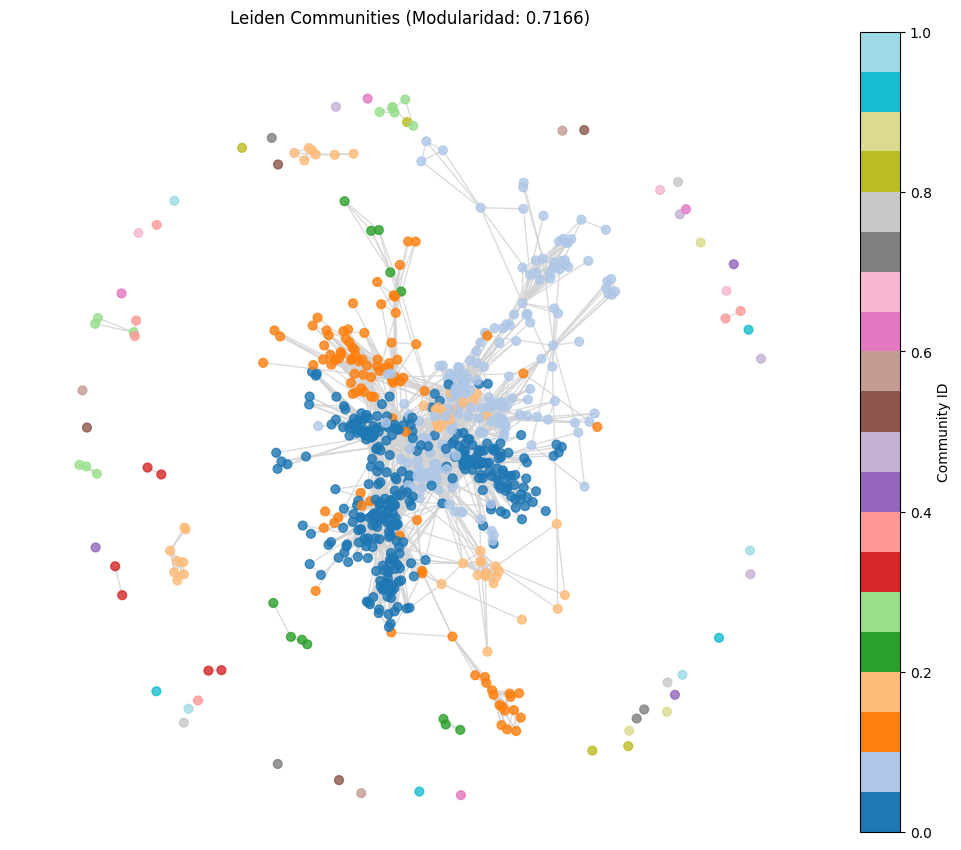


Datos de la comunidad guardados en '../../data/networks/nodes_with_communities_leiden.csv'
   author_id  Community_ID
0     542507             0
1     755858             0
2     128660             0
3     357936             0
4     737487             0


In [2]:
import pandas as pd
import networkx as nx
import igraph as ig
import leidenalg
import matplotlib.pyplot as plt
import json

# === 1. CARGAR DATOS ===
nodos = pd.read_csv("../../data/networks/nodos_IPBLN.csv")
enlaces = pd.read_csv("../../data/networks/coautorias_IPBLN.csv")

# === 2. CONSTRUIR GRAFO CON NETWORKX (para visualización) ===
G_nx = nx.Graph()

for _, row in nodos.iterrows():
    G_nx.add_node(row["author_id"], label=row["Label"])

for _, row in enlaces.iterrows():
    G_nx.add_edge(row["Source"], row["Target"], weight=row["Weight"])

# === 3. CONVERTIR A iGraph ===
G_ig = ig.Graph()

# Mapeo de author_id a índice entero
author_id_to_idx = {author_id: idx for idx, author_id in enumerate(G_nx.nodes())}
idx_to_author_id = {v: k for k, v in author_id_to_idx.items()}

G_ig.add_vertices(len(author_id_to_idx))
G_ig.vs['author_id'] = list(author_id_to_idx.keys())

edges_ig = [
    (author_id_to_idx[row["Source"]], author_id_to_idx[row["Target"]])
    for _, row in enlaces.iterrows()
]
weights = list(enlaces["Weight"])
G_ig.add_edges(edges_ig)
G_ig.es['weight'] = weights

# === 4. APLICAR LEIDEN ===
partition = leidenalg.find_partition(G_ig, leidenalg.RBConfigurationVertexPartition, weights='weight', resolution_parameter=1.0)

# === 5. MODULARIDAD ===
modularity = partition.modularity
print(f"Comunidades detectadas: {len(partition)}")
print(f"Modularidad: {modularity:.4f}")

# === 6. VISUALIZACIÓN CON NETWORKX ===
# Mapeo de índice de comunidad a nodos
node_community_map = {}
for comm_id, comm in enumerate(partition):
    for idx in comm:
        author_id = idx_to_author_id[idx]
        node_community_map[author_id] = comm_id

colors = [node_community_map[node] for node in G_nx.nodes()]
pos = nx.spring_layout(G_nx, seed=42)

plt.figure(figsize=(10, 8))
nx.draw(
    G_nx,
    pos,
    node_color=colors,
    with_labels=False,
    node_size=40,
    cmap=plt.cm.tab20,
    edge_color='lightgray',
    alpha=0.8
)
plt.title(f"Leiden Communities (Modularidad: {modularity:.4f})")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.tab20), ax=plt.gca(), orientation='vertical', label='Community ID')
plt.show()

# === 7. GUARDAR COMO JSON ===
with open("partition_leiden.json", "w", encoding='utf-8') as f:
    json.dump([[idx_to_author_id[idx] for idx in comm] for comm in partition], f)

# === 8. GUARDAR COMO CSV ===
df_communities = pd.DataFrame([
    {'author_id': idx_to_author_id[idx], 'Community_ID': comm_id}
    for comm_id, comm in enumerate(partition)
    for idx in comm
])
output_filename = '../../data/networks/nodes_with_communities_leiden.csv'
df_communities.to_csv(output_filename, index=False)
print(f"\nDatos de la comunidad guardados en '{output_filename}'")
print(df_communities.head())
